In [1]:
# time, jerseyNumber, team       , event      , closeTeams, distantTeams, closeOps, distantOps, coordinate , velocity   , playId
# int , int         , encoded int, encoded int, set       , set         , set     , set       , tuple float, tuple float, int
import sys
from PCMCI.find import *
import pandas as pd
from datetime import datetime

In [ ]:
df = pd.read_csv('../NFL Tracking/WK3_Ram_VS_49ers.csv', usecols=['time','jerseyNumber', 'team', 'x', 'y', 'speed', 'direction', 'event', 'frameId', 'playId'])
start_time_str = '2017-09-22T00:26:36Z'
end_time_str = '2017-09-22T03:50:05Z'

start_time = datetime.strptime(start_time_str, '%Y-%m-%dT%H:%M:%SZ')
end_time = datetime.strptime(end_time_str, '%Y-%m-%dT%H:%M:%SZ')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%SZ')
df_filtered = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
df_filtered['time'] = df_filtered['time'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

df = df_filtered
df.to_csv('temp.csv', index=False)



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Reduce to 1 record every second
df_avg = pd.DataFrame(columns=df.columns)
new_rows = []

base_time = datetime.strptime('2017-09-22T00:26:36Z', '%Y-%m-%dT%H:%M:%SZ')

row = 0
while row < len(df):
    avg_x = 0
    avg_y = 0
    avg_speed = 0
    avg_direction = 0
    start_time = df.iloc[row]['time']
    event = 'none'
    chunk = pd.DataFrame(columns=df.columns)
    temp = []
    while row < len(df):
        if df.iloc[row]['time'] == start_time:
            temp.append(df.iloc[row])
            if not pd.isnull(df.iloc[row]['event']):
                event = df.iloc[row]['event']
        row += 1
    if len(temp) == 10:
        chunk = pd.concat([chunk, pd.DataFrame(temp)], ignore_index=True)
        time = int((datetime.strptime(
            start_time, '%Y-%m-%dT%H:%M:%SZ') - base_time).total_seconds())
        jerseyNumber = int(df.iloc[row]['jerseyNumber'])
        team = 0 if df.iloc[row]['team'] == 'home' else 1
        avg_x = round(chunk['x'].mean(), 2)
        avg_y = round(chunk['y'].mean(), 2)
        avg_speed = round(chunk['speed'].mean(), 2)
        avg_direction = round(chunk['direction'].mean(), 2)
        playId = df.iloc[row]['playId']

        new_rows.append({'time': time, 'jerseyNumber': jerseyNumber, 'team': team, 'x': avg_x, 'y': avg_y,
                        'speed': avg_speed, 'direction': avg_direction, 'event': event, 'playId': playId})
    # else:
    #     print(f'Row from {row-len(temp)} to {row} only has {len(temp)} records')

df_avg = pd.concat([df_avg, pd.DataFrame(new_rows)], ignore_index=True)
df_avg.to_csv('temp_avg.csv', index=False)

In [36]:
df_avg = pd.read_csv('temp_avg.csv')
behaviours = set()
for row in df_avg.iterrows():
    behaviours.add(row[1]['event'])
behaviour_list = sorted(list(behaviours))
behaviour_map = {behaviour: i for i, behaviour in enumerate(behaviour_list)}
for b, i in behaviour_map.items():
    print(f'{b}: {i}')

ball_snap: 0
extra_point: 1
extra_point_attempt: 2
extra_point_missed: 3
fair_catch: 4
field_goal: 5
field_goal_attempt: 6
first_contact: 7
fumble: 8
fumble_defense_recovered: 9
handoff: 10
kick_received: 11
kickoff: 12
kickoff_land: 13
line_set: 14
man_in_motion: 15
none: 16
onside_kick: 17
out_of_bounds: 18
pass_arrived: 19
pass_forward: 20
pass_outcome_caught: 21
pass_outcome_incomplete: 22
pass_outcome_interception: 23
pass_outcome_touchdown: 24
pass_tipped: 25
punt: 26
punt_land: 27
punt_muffed: 28
punt_received: 29
qb_kneel: 30
qb_sack: 31
run: 32
tackle: 33
touchback: 34
touchdown: 35


In [40]:
'''
ball_snap: 0
extra_point: 1
extra_point_attempt: 2
extra_point_missed: 3
fair_catch: 4
field_goal: 5
field_goal_attempt: 6
first_contact: 7
fumble: 8
fumble_defense_recovered: 9
fumble_offense_recovered: 10
handoff: 11
kick_received: 12
kick_recovered: 13
kickoff: 14
kickoff_land: 15
kickoff_play: 16
line_set: 17
man_in_motion: 18
none: 19
onside_kick: 20
out_of_bounds: 21
pass_arrived: 22
pass_forward: 23
pass_outcome_caught: 24
pass_outcome_incomplete: 25
pass_outcome_interception: 26
pass_outcome_touchdown: 27
pass_tipped: 28
punt: 29
punt_land: 30
punt_play: 31
punt_received: 32
qb_kneel: 33
qb_sack: 34
run: 35
shift: 36
tackle: 37
touchback: 38
touchdown: 39
'''
from find import *

def distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

df = pd.DataFrame(columns=['time', 'jerseyNumber', 'team', 'behaviour', 'closeTeams', 'distantTeams', 'closeOps', 'distantOps', 'coordinate', 'velocity', 'playId'])
df_avg = pd.read_csv('temp_avg_fix.csv')
new_rows = []
for time in range(0, df_avg['time'].max()+1):
    play = searchDF(df_avg, [('time', time)])
    for player in play.iterrows():
        teammates = searchDF(play, [('team', player[1]['team']), ('jerseyNumber', '!'+str(player[1]['jerseyNumber']))])
        opponents = searchDF(play, [('team', '!'+str(player[1]['team']))])
        
        closeTeams = set()
        distantTeams = set()
        closeOps = set()
        distantOps = set()
        radius = 5

        for teammate in teammates.iterrows():
            if distance(player[1]['x'], player[1]['y'], teammate[1]['x'], teammate[1]['y']) < radius:
                closeTeams.add(teammate[1]['jerseyNumber'])
            else:
                distantTeams.add(teammate[1]['jerseyNumber'])

        for opponent in opponents.iterrows():
            if distance(player[1]['x'], player[1]['y'], opponent[1]['x'], opponent[1]['y']) < radius:
                closeOps.add(opponent[1]['jerseyNumber'])
            else:
                distantOps.add(opponent[1]['jerseyNumber'])

        new_rows.append({'time': time, 'jerseyNumber': player[1]['jerseyNumber'], 'team': player[1]['team'], 'behaviour': behaviour_map[player[1]['event']], 'closeTeams': closeTeams, 'distantTeams': distantTeams, 'closeOps': closeOps, 'distantOps': distantOps, 'coordinate': (player[1]['x'], player[1]['y']), 'velocity': (player[1]['speed'], player[1]['direction']), 'playId': player[1]['playId']})
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
df.to_csv('causal_data_5.csv', index=False)

In [8]:
with open('causal_data.csv', "r") as file:
    content = file.read()

# Replace all occurrences of 'set()' with '{}'
updated_content = content.replace("set()", "{}")

# Write the updated content to a new file
with open('causal_data_2.csv', "w") as file:
    file.write(updated_content)

In [3]:
# Imports
import pandas as pd
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
# %matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI


In [41]:
# ACTUAL CODE
import ast

df = pd.read_csv('causal_data_5.csv')
df = df.drop(columns=['playId'])
df[['coordinate_x', 'coordinate_y']] = pd.DataFrame(df['coordinate'].apply(lambda x: list(ast.literal_eval(x))).to_list(), index=df.index)
df[['speed', 'direction']] = pd.DataFrame(df['velocity'].apply(lambda x: list(ast.literal_eval(x))).to_list(), index=df.index)
df = df.drop(columns=['coordinate', 'velocity'])

def expand_sets(df, set_columns, max_elements):
    for column in set_columns:
        for i in range(max_elements):
            df[f'{column}_{i+1}'] = df[column].apply(lambda x: sorted(list(ast.literal_eval(x)))[i] if i < len(ast.literal_eval(x)) else -1)
    return df

set_columns = ['closeTeams', 'distantTeams', 'closeOps', 'distantOps']
max_close_teams = 10   # up to 10 teams
max_distant_teams = 10  # up to 10 distant teams
max_close_ops = 11      # up to 11 operations
max_distant_ops = 11    # up to 11 distant operations

df = expand_sets(df, ['closeTeams'], max_close_teams)
df = expand_sets(df, ['distantTeams'], max_distant_teams)
df = expand_sets(df, ['closeOps'], max_close_ops)
df = expand_sets(df, ['distantOps'], max_distant_ops)
df = df.drop(columns=['closeTeams', 'distantTeams', 'closeOps', 'distantOps'])

df.to_csv('causal_data_6.csv', index=False)


In [4]:
import pandas as pd
# time,jerseyNumber,team,behaviour,coordinate_x,coordinate_y,speed,direction,closeTeams_1,closeTeams_2,closeTeams_3,closeTeams_4,closeTeams_5,closeTeams_6,closeTeams_7,closeTeams_8,closeTeams_9,closeTeams_10,distantTeams_1,distantTeams_2,distantTeams_3,distantTeams_4,distantTeams_5,distantTeams_6,distantTeams_7,distantTeams_8,distantTeams_9,distantTeams_10,closeOps_1,closeOps_2,closeOps_3,closeOps_4,closeOps_5,closeOps_6,closeOps_7,closeOps_8,closeOps_9,closeOps_10,closeOps_11,distantOps_1,distantOps_2,distantOps_3,distantOps_4,distantOps_5,distantOps_6,distantOps_7,distantOps_8,distantOps_9,distantOps_10,distantOps_11
df = pd.read_csv('causal_data_2.csv')
df['time'] = df['time'].apply(int)
df['jerseyNumber'] = df['jerseyNumber'].apply(int)
df['team'] = df['team'].apply(int)
df['behaviour'] = df['behaviour'].apply(int)
df['coordinate_x'] = df['coordinate_x'].apply(float)
df['coordinate_y'] = df['coordinate_y'].apply(float)
df['speed'] = df['speed'].apply(float)
df['direction'] = df['direction'].apply(float)
for column in ['closeTeams', 'distantTeams', 'closeOps', 'distantOps']:
    for i in range(1, 11):
        df[f'{column}_{i}'] = df[f'{column}_{i}'].apply(int)
df['closeOps_11'] = df['closeOps_11'].apply(int)
df['distantOps_11'] = df['distantOps_11'].apply(int)

In [1]:
import pickle
import os
TAU_MAX = 5
save_folder = 'save_5'
file_path = 'causal_data_5.csv'

if not os.path.exists(save_folder):
    os.makedirs(save_folder)


In [4]:

df = pd.read_csv(file_path)
datatime = {0: df['time'].to_numpy()}
df = df.drop('time', axis=1)
var_names = list(df.columns)
tigramite_df = pp.DataFrame(df.to_numpy(), datatime=datatime, var_names=var_names)
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=tigramite_df, cond_ind_test=parcorr, verbosity=1)
with open(f'{save_folder}/pcmci.pkl', 'wb') as f:
    pickle.dump(pcmci, f)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 5


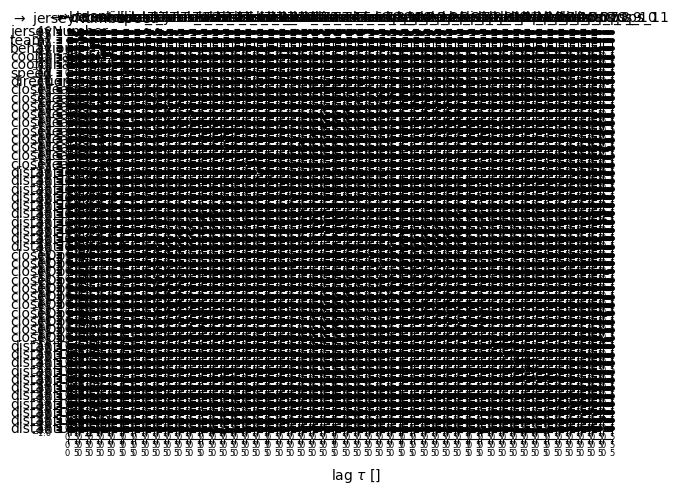


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable jerseyNumber has 64 link(s):
    [pc_alpha = 0.5]
        (jerseyNumber -1): max_pval = 0.00000, |min_val| =  0.345
        (jerseyNumber -4): max_pval = 0.00000, |min_val| =  0.209
        (jerseyNumber -5): max_pval = 0.00000, |min_val| =  0.179
        (jerseyNumber -3): max_pval = 0.00000, |min_val| =  0.050
        (closeTeams_5 -4): max_pval = 0.00000, |min_val| =  0.039
        (distantOps_1 -2): max_pval = 0.00000, |min_val| =  0.037
        (team -5): max_pval = 0.00000, |min_val| =  0.036
        (closeTeams_9 -2): max_pval = 0.00000, |min_val| =  0.033
        (distantOps_7 -5): max_pval = 0.00000, |min_val| =  0.033
        (distantTeams_1 -5): max_pval = 0.00000, |min_val| =  0.031
        (distantTeams_4 

<Figure size 640x480 with 0 Axes>

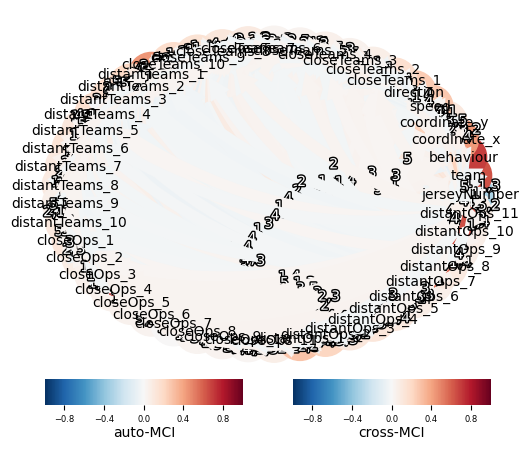

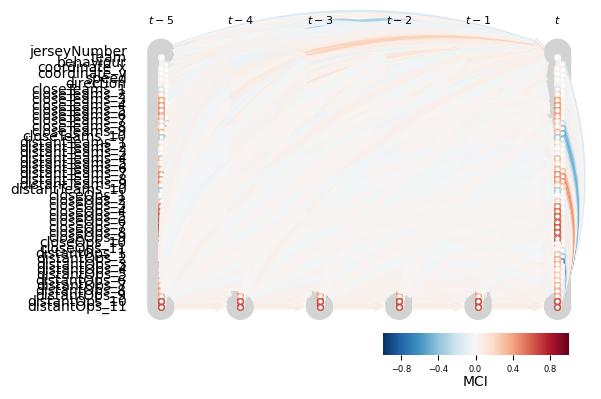

In [5]:
import pickle

correlations = pcmci.get_lagged_dependencies(tau_max=TAU_MAX, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()
plt.savefig(f'{save_folder}/lagfuncs.png')

results = pcmci.run_pcmci(tau_max=TAU_MAX, pc_alpha=None, alpha_level=0.01)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=TAU_MAX, link_assumptions=None)
results['graph'] = graph

with open(f'{save_folder}/results.pkl', 'wb') as f:
    pickle.dump(results, f)

tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    );
plt.savefig(f'{save_folder}/graph.png')

tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    );
plt.savefig(f'{save_folder}/time_series_graph.png')

tp.write_csv(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    save_name=f'{save_folder}/links.csv',
    digits=5,
)

In [6]:
from tigramite.models import LinearMediation, Prediction

results = pickle.load(open(f'{save_folder}/results.pkl', 'rb'))
graph = results['graph']
T = list(tigramite_df.T.values())[0]
pred = Prediction(dataframe=tigramite_df,
        cond_ind_test=ParCorr(),   #CMIknn ParCorr
        prediction_model = sklearn.linear_model.LinearRegression(),
#         prediction_model = sklearn.gaussian_process.GaussianProcessRegressor(),
        # prediction_model = sklearn.neighbors.KNeighborsRegressor(),
    data_transform=None,
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.9*T), T),
    verbosity=1
    )
# target = var_names.index('behaviour')
target = 3
predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=1,
                  tau_max=TAU_MAX,
                  pc_alpha=None
                  )
pred.fit(target_predictors=predictors, 
                selected_targets=[target],
                    tau_max=TAU_MAX)

predicted = pred.predict(target)
true_data = pred.get_test_array(j=target)[0]



##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable jerseyNumber has 64 link(s):
    [pc_alpha = 0.5]
        (jerseyNumber -1): max_pval = 0.00000, |min_val| =  0.319
        (jerseyNumber -4): max_pval = 0.00000, |min_val| =  0.206
        (jerseyNumber -5): max_pval = 0.00000, |min_val| =  0.191
        (jerseyNumber -3): max_pval = 0.00000, |min_val| =  0.057
        (distantOps_7 -5): max_pval = 0.00000, |min_val| =  0.050
        (distantOps_1 -2): max_pval = 0.00000, |min_val| =  0.044
        (closeTeams_5 -4): max_pval = 0.00000, |min_val| =  0.040
        (team -5): max_pval = 0.00000, |min_val| =  0.037
        (closeTeams_1 -5): max_pval = 0.00000, |min_val| =  0.037
        (closeTeams_9 -2): max_pval = 0.00005, |min_val| =  0.030
        (distantTeams_5 -2

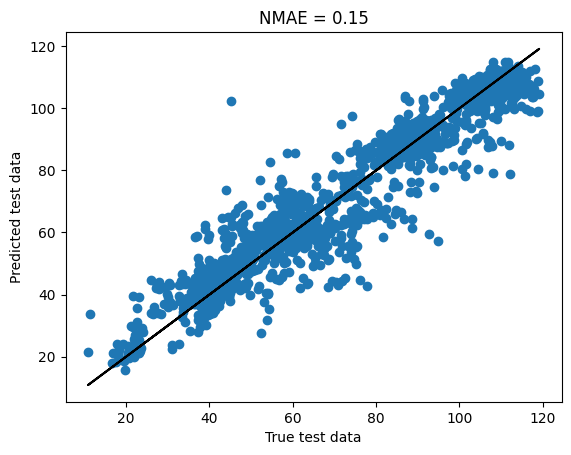

In [7]:

plt.scatter(true_data, predicted)
plt.title(r"NMAE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
plt.savefig(f'{save_folder}/prediction_nmae.png')
plt.show()

In [8]:
with open(f'{save_folder}/pred.pkl', 'wb') as f:
    pickle.dump(pred, f)

In [9]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Load dataset and PCMCI link file
df = pd.read_csv(file_path)
links = pd.read_csv(f"{save_folder}/links.csv")

# Check if the dataset is loaded correctly
if df.empty:
    raise ValueError("Dataset is empty!")
if links.empty:
    raise ValueError("Links file is empty!")

# Create node features (excluding only non-numeric and target column)
node_features = df.drop(columns=['behaviour']).values
target = df['behaviour'].values

# Ensure node features and target are not empty
if node_features.size == 0 or target.size == 0:
    raise ValueError("Node features or target are empty!")

# Create edge list and weights
edge_index = []  # Stores source and target node indices
edge_weight = []  # Stores edge weights

node_map = {jersey: idx for idx, jersey in enumerate(df['jerseyNumber'].unique())}

# Process links and add edges
for _, row in links.iterrows():
    if row['Variable i'] in node_map and row['Variable j'] in node_map:
        i = node_map[row['Variable i']]
        j = node_map[row['Variable j']]
        edge_index.append([i, j])
        edge_weight.append(row['Link value'])

# If no edges exist, add self-loops with weight 0
if not edge_index:
    print("No edges found, adding self-loops with weight 0.")
    edge_index = [[i, i] for i in range(len(node_map))]
    edge_weight = [0.0] * len(node_map)  # Assign a weight of 0 for each self-loop

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)
nodes = torch.tensor(node_features, dtype=torch.float)
target = torch.tensor(target, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=nodes, edge_index=edge_index, edge_attr=edge_weight, y=target)


No edges found, adding self-loops with weight 0.


In [10]:

# Define the GNN Model
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return F.log_softmax(x, dim=1)

# Initialize model, loss, and optimizer
model = GNNModel(in_channels=nodes.shape[1], hidden_channels=16, out_channels=len(torch.unique(target)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 0, Loss: 159.5072
Epoch 10, Loss: 23.6767
Epoch 20, Loss: 6.0570
Epoch 30, Loss: 3.5559
Epoch 40, Loss: 3.3680
Epoch 50, Loss: 3.2442
Epoch 60, Loss: 3.1311
Epoch 70, Loss: 3.0293
Epoch 80, Loss: 2.9384
Epoch 90, Loss: 2.5580
Epoch 100, Loss: 2.2546
Epoch 110, Loss: 2.2176
Epoch 120, Loss: 2.2028
Epoch 130, Loss: 2.1957
Epoch 140, Loss: 2.1922
Epoch 150, Loss: 2.1904
Epoch 160, Loss: 2.1893
Epoch 170, Loss: 2.1885
Epoch 180, Loss: 2.1878
Epoch 190, Loss: 2.1872


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def save_model(model, optimizer, epoch, file_path=f"{save_folder}/gnn_model.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)
    print(f"Model saved to {file_path}")

def save_data(data, file_path=f"{save_folder}/gnn_data.pth"):
    torch.save(data, file_path)
    print(f"Data saved to {file_path}")
    
def load_model(model, optimizer, file_path=f"{save_folder}/gnn_model.pth"):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Model loaded from {file_path}, starting from epoch {epoch}")
    return model, optimizer, epoch

def load_data(file_path=f"{save_folder}/gnn_data.pth"):
    data = torch.load(file_path)
    print(f"Data loaded from {file_path}")
    return data

# Save the model
save_model(model, optimizer, epoch)
save_data(data)
# model, optimizer, epoch = load_model(model, optimizer)
# data = load_data()

def evaluate(model, data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for evaluation
        out = model(data)  # Get the model's predictions
        predictions = out.argmax(dim=1)  # Get the class with the highest probability
        accuracy = accuracy_score(data.y.numpy(), predictions.numpy())  # Compute accuracy
        precision = precision_score(data.y.numpy(), predictions.numpy(), average='weighted')
        recall = recall_score(data.y.numpy(), predictions.numpy(), average='weighted')
        f1 = f1_score(data.y.numpy(), predictions.numpy(), average='weighted')
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate(model, data)
print(f"Accuracy: {accuracy*100:.4f}, Precision: {precision*100:.4f}, Recall: {recall*100:.4f}, F1: {f1*100:.4f}")

Model saved to save_5/gnn_model.pth
Data saved to save_5/gnn_data.pth
Accuracy: 41.3001, Precision: 33.4957, Recall: 41.3001, F1: 24.1712


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# FOR DATA_3
import ast

df = pd.read_csv('causal_data_3.csv')
df = df.drop(columns=['playId'])
df[['coordinate_x', 'coordinate_y']] = pd.DataFrame(df['coordinate'].apply(lambda x: list(ast.literal_eval(x))).to_list(), index=df.index)
df[['speed', 'direction']] = pd.DataFrame(df['velocity'].apply(lambda x: list(ast.literal_eval(x))).to_list(), index=df.index)
df = df.drop(columns=['coordinate', 'velocity'])

df['closeTeams'] = df['closeTeams'].apply(lambda x: len(ast.literal_eval(x)))
df['distantTeams'] = df['distantTeams'].apply(lambda x: len(ast.literal_eval(x)))
df['closeOps'] = df['closeOps'].apply(lambda x: len(ast.literal_eval(x)))
df['distantOps'] = df['distantOps'].apply(lambda x: len(ast.literal_eval(x)))

df.to_csv('causal_data_3.csv', index=False)

In [22]:
# FOR DATA_4_0 and DATA_4_1
import pandas as pd
df = pd.read_csv('causal_data_3.csv')
df = df[df["team"] == 1]
df = df.drop(columns=['team'])
# df = df.drop(columns=['jerseyNumber'])
df.to_csv('causal_data_4_1.csv', index=False)

In [35]:
# Correct the time values
df = pd.read_csv('temp_avg.csv')
sorted_df = df.sort_values(by=['time', 'playId', 'frameId', 'team', 'jerseyNumber'])
times = sorted_df['time'].unique()
time_map = {times[i]: i for i in range(len(times))}
sorted_df['time'] = sorted_df['time'].apply(lambda x: time_map[x])
sorted_df.to_csv('temp_avg_fix.csv', index=False)